``Start modelling on metadata again. No imgs only metadata.``

```ONLY one thing: IMPROVE```


# Load data and dependencies

In [1]:
import warnings
import sys
import os
import time
import joblib
import random
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from joblib import Parallel, delayed

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, minmax_scale
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

warnings.filterwarnings('ignore')

In [2]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

# Utils

In [3]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [4]:
def dens_to_sev(x: float)-> int:
    """takes in density value in cells/ml and returns severity category"""
    if (x < 20_000) : return 1
    elif (x >= 20_000) and (x < 100_000) : return 2
    elif (x >= 100_000) and (x < 1_000_000) : return 3
    elif (x >= 1_000_000) and (x < 10_000_000) : return 4
    elif x > 10_000_000 : return 5

In [5]:
def region_wise_peformance(y_data=None, preds=None):
    """
    returns classifcation report for each region
    y_data : pd.DataFrame
    preds : np.array
    
    """
    y_data = y_data.copy(deep=True)
    y_data['preds'] = preds
    for region in sorted(y_data.region.unique()):
        print(region)
        print(classification_report(y_data[y_data.region == region].severity, y_data[y_data.region == region].preds))
        print()
    

In [6]:
#  Utils
def get_data_by_date( date=None, data=None):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

def analyize_matches(y_true, y_pred, plot=False):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))
    
    stupid_vals = []
    for i in range(1, 6):
        stupid_vals.append(
            ((sum([1 for x, y in zip(y_true, y_pred) if x == i and y == i])/len(y_true))*100, (sum(y_true == i)/len(y_true))*100)
            )

    print()
    for i in range(5):
        print(f"Severity {i+1} : accuracy: {np.round(stupid_vals[i][0], 3)} % - prevalence: {np.round(stupid_vals[i][1], 3)} %")
    
    try:
        print()
        print("Classification report:")
        print(classification_report(y_true, y_pred))
    except Exception as e:
        print(e)
        print("Classification report failed")
        
    if plot:
        print()
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds')

# Add date fts

In [18]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week

seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

reg_sev_map = {
    'midwest': 2,
    'northeast': 2,
    'south' : 2,
    'west' : 4
}

reg_map = {
    'south' : 0,
    'northeast' : 1,
    'west' : 2,
    'midwest' : 3
}

metadata['season'] = metadata.month.map(seasons)

region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

all_data = pd.merge(metadata, region, on='uid', how='left')
data = all_data.copy(deep=True)
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0


# CV

In [135]:
def train_eval(model, X_train=None, X_val=None, y_train=None, y_val=None, X_test=None, y_test=None, task='reg'):
    """
    train and eval util func,
    returns trained model, soft_preds, and tr, val, test rmses
    REMEMBER returns soft-preds
    """
    
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    if task == 'reg':
        val_rmse = rmse(y_val, np.clip(np.round(val_preds), 1, 5))
        train_rmse = rmse(y_train, np.clip(np.round(model.predict(X_train)), 1, 5))   # don't forget to clip!
    else:
        val_rmse = rmse(y_val, val_preds)
        train_rmse = rmse(y_train, model.predict(X_train))
        
    print("Train RMSE: ", train_rmse)
    print("Val RMSE:", val_rmse)
    if X_test is not None and y_test is not None:
        if task == 'reg':
            test_rmse = mse(y_test, np.clip(np.round(model.predict(X_test)), 1, 5), squared=False)
        else:
            test_rmse = mse(y_test, model.predict(X_test), squared=False)
        print('TEST RMSE: ', test_rmse)
    else:
        test_rmse = 0
        
    # print("TEST RMSE:", mse(y_val, np.round(model.predict(X_val)), squared=False))
    return model, val_preds, train_rmse, val_rmse, test_rmse

In [136]:

def cv_it(model, X_train=None, y_train=None, X_test=None, y_test=None, splits=10, cv_predict=False, task='reg'):
    """ 
    cv in stratified kfold fashion, 
    returns train, val, test rmses, and cv preds for test and train if cv_predict=True
    remember to round preds
    And also send in "dates" to make val set similar to test set
    """
    
    skf = StratifiedKFold(n_splits=splits, random_state=12_000, shuffle=True)
    # tscv = TimeSeriesSplit(n_splits=splits, test_size=200)
    print('Using cols: ', X_train.columns.values)

    train_rmses = []
    val_rmses = []
    test_rmses = []
    cvpreds_test, cvpreds_train = None, None

    if cv_predict:
        if X_test is not None: test_shape = X_test.shape[0]
        else: test_shape = 6510
        cvpreds_test = np.zeros(shape=(test_shape, splits))
        cvpreds_train = np.zeros(shape=(len(X_train)))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

        print(f'----------------------------------Fold-{fold}------------------------------------')
        X_train_subset, y_train_subset = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        try:
            # make val set more similar to test set by making val_set.latlng.isin(trian_set.latlng) --> 0
            X_val_subset['latlng'] = X_val_subset.latitude.astype(str) + '_' + X_val_subset.longitude.astype(str)
            X_train_subset['latlng'] = X_train_subset.latitude.astype(str) + '_' + X_train_subset.longitude.astype(str)

            drp_idx = X_val_subset[X_val_subset.latlng.isin(X_train_subset.latlng)].index
            
            # X_train_subset = pd.concat([X_train_subset, X_val_subset.loc[drp_idx]], axis=0) # causes cv leak
            # y_train_subset = pd.concat([y_train_subset, y_val_subset.loc[drp_idx]], axis=0)

            X_val_subset.drop(drp_idx, inplace=True)
            y_val_subset.drop(drp_idx, inplace=True)
            
            # make sure no latlng is in both train and val_data
            assert X_val_subset.latlng.isin(X_train_subset.latlng).sum() == 0
            
            # drop latlng
            X_val_subset.drop('latlng', axis=1, inplace=True)
            X_train_subset.drop('latlng', axis=1, inplace=True)

        except Exception as e:
            print('Error in making val set more similar to test set')
            print(e)
        
        assert X_train_subset.columns.tolist() == X_val_subset.columns.tolist()
        # assert X_train_subset.columns.tolist() == X_test.columns.tolist()

        print(f'Training on {X_train_subset.shape[0]} samples' )
        print(f'Validating on {X_val_subset.shape[0]} samples' )

        print(y_val_subset.value_counts(normalize=True))
        model, val_preds, train_rmse, val_rmse, test_rmse= train_eval(
                                    model=model, 
                                    X_train=X_train_subset, 
                                    y_train=y_train_subset, 
                                    X_val=X_val_subset, 
                                    y_val=y_val_subset,
                                    X_test=X_test,
                                    y_test=y_test,
                                    task=task
                                    )

        sns.barplot(model.feature_importances_, model.feature_names_in_)

        val_rmses.append(val_rmse)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        
        if cv_predict:
            # save predictions for ensembling
            if X_test is not None:
                cvpreds_test[:, fold] = model.predict(X_test)
            cvpreds_train[val_idx] = model.predict(X_train.iloc[val_idx])
                    
    print()
    print("Mean Train RMSE:", np.mean(train_rmses), "std:", np.std(train_rmses))
    print("Mean Val RMSE:", np.mean(val_rmses), "std:", np.std(val_rmses))
    print("Mean Test RMSE:", np.mean(test_rmses), "std:", np.std(test_rmses))
    
    return cvpreds_test, cvpreds_train, np.mean(train_rmses), np.mean(val_rmses), np.mean(test_rmses)

# KNN

In [10]:
def knn(row=None, train_data=None, k=1):
    """
    row : pd.Series (row from val_data)
    train_data : pd.DataFrame (all_data)
    k : int number of nearest neighbours to consider
    
    algo:
    1. Get past month data collected till the current row
    2. Get the k nearest neighbours (geodesic dist using lat, lng) from the above data
    3. Get the mean of the severity from the above rows
    4. Return the mean of the nearest neighbours severity

    """
    
    if row is None:
        print('Row None bruv!')
        return None
    
    uid = row.uid
    date = row.date
    region = row.region
    past_date = date - pd.Timedelta(days=30)
    
    past_month_data = train_data[(train_data.date < date) & (train_data.date >= past_date)]
    past_month_data.sort_values(by='date', inplace=True)
    
    # if no past data, return the mean of the region
    if len(past_month_data) == 0:
        return reg_sev_map[region]
        
    dist_matrix =pd.DataFrame(columns=['uid', 'dist'])       # 0th col for uid, 1st col for dist
    for i, past_row in enumerate(past_month_data.itertuples()):
        dist_matrix.loc[i, 'uid'] = past_row.uid
        dist_matrix.loc[i, 'dist'] = get_distance(row.latitude, row.longitude, past_row.latitude, past_row.longitude)   # returns geodesic dist in km

    # get mean of top k nearest neighbours
    n_uids = dist_matrix.sort_values(by='dist').head(k).uid.values
    nn_severity = train_data[train_data.uid.isin(n_uids)].severity.mean()
    
    return np.round(nn_severity)


In [11]:
def knn_wrapper(k=15, train_data=None, val_data=None):
    sev_list = Parallel(n_jobs=-1, backend='loky')([delayed(knn)(row, train_data=train_data, k=k) for row in val_data.itertuples()])
    return sev_list

# Adding features

## Expanding fts.

In [12]:
data = all_data.sort_values(by='date')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


In [13]:
train_data_ = data[data.split == 'train']
train_data_.severity.value_counts(normalize=True)

1.0    0.439449
4.0    0.207913
2.0    0.189859
3.0    0.159379
5.0    0.003400
Name: severity, dtype: float64

In [14]:
grp_by_rm = data.groupby(['region', 'month']).severity.expanding(1).mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  
grp_by_rm.fillna(grp_by_rm.groupby('region').transform('mean'), inplace=True)
print(grp_by_rm.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))

# remember rmse is not representative of test set!!
# this is slightly better than the all 1s

72
0
Exact matches:  0.5014067995310668
Missed by 1:  0.44021101992966
Missed by 2:  0.04824150058616647
Missed by 3:  0.009730363423212192
Missed by 4:  0.00041031652989449003

Severity 1 : accuracy: 19.965 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.767 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.545 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.864 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.72      0.45      0.56      7497
         2.0       0.26      0.67      0.37      3239
         3.0       0.18      0.03      0.06      2719
         4.0       0.86      0.81      0.84      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.50     17060
   macro avg       0.40      0.39      0.36     17060
weighted avg       0.57      0.50      0.50     17060



0.8528278592784991

In [15]:
data['exp_grp_by_rm'] = grp_by_rm.droplevel(0).droplevel(0).loc[data.index]
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,exp_grp_by_rm
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0,1.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,1.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,1.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0,1.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,4.0


In [17]:
grp_by_rs = data.groupby(['region', 'season']).severity.expanding(1).mean()
grp_by_rs = grp_by_rs.map(np.round)
print(grp_by_rs.isna().sum())  
grp_by_rs.fillna(grp_by_rs.groupby('region').transform('mean'), inplace=True)
print(grp_by_rs.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), grp_by_rs.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(grp_by_rs.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))


5
0
Exact matches:  0.5026377491207503
Missed by 1:  0.4370457209847597
Missed by 2:  0.04882766705744431
Missed by 3:  0.011078546307151231
Missed by 4:  0.00041031652989449003

Severity 1 : accuracy: 19.66 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.749 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.047 % - prevalence: 15.938 %
Severity 4 : accuracy: 17.808 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.71      0.45      0.55      7497
         2.0       0.25      0.67      0.37      3239
         3.0       0.04      0.00      0.01      2719
         4.0       0.85      0.86      0.85      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.50     17060
   macro avg       0.37      0.40      0.36     17060
weighted avg       0.54      0.50      0.49     17060



0.8594349134502333

In [ ]:
data['exp_grp_by_rs'] = grp_by_rs.droplevel(0).droplevel(0).loc[data.index]
data

In [ ]:
grp_by_rw = data.groupby(['region', 'week']).severity.expanding(1).mean()
grp_by_rw = grp_by_rw.map(np.round)
print(grp_by_rw.isna().sum())  
grp_by_rw.fillna(grp_by_rw.groupby('region').transform('mean'), inplace=True)
print(grp_by_rw.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), grp_by_rw.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(grp_by_rw.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))


In [ ]:
data['exp_grp_by_rw'] = grp_by_rw.droplevel(0).droplevel(0).loc[data.index]
data

In [ ]:
data[data.columns[data.columns.str.startswith('exp')]].corr()
# wonder if these are useful!

## Rolling fts.

In [ ]:
# best rolling window is 7 days

In [ ]:
data = all_data.sort_values(by='date')
train_data = data[data.split == 'train']
test_data =  data[data.split == 'test']

data

In [ ]:
x = data.groupby('region').severity.rolling(7, min_periods=1).mean().map(np.round).fillna(data.groupby('region').severity.transform('mean')).isna()
x.droplevel(0).loc[data.index]

In [ ]:
data[x.droplevel(0).loc[data.index]].index

In [ ]:
data[x.droplevel(0).loc[data.index]].index.isin(test_data.index).sum()

# Split

In [321]:
test_data = data[data.split == 'test']
test_data.shape, data.shape

((6510, 12), (23570, 12))

In [322]:
train_data = data[data.split == 'train']
train_data.shape, data.shape

((17060, 12), (23570, 12))

In [323]:
tr_data, val_data = train_test_split(train_data, test_size=0.15, random_state=123456789, shuffle=True)
tr_data.shape, val_data.shape

((14501, 12), (2559, 12))

In [324]:
X_test = test_data[train_data.columns]
X_test

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
12,aair,33.042600,-117.076000,2014-11-01,test,2014,11,44,4,west,NaN,NaN
14,aajw,40.703968,-80.293050,2015-08-26,test,2015,8,35,3,northeast,NaN,NaN
15,aalr,38.972500,-94.672930,2019-08-26,test,2019,8,35,3,midwest,NaN,NaN
16,aalw,34.279000,-118.905000,2018-01-08,test,2018,1,2,1,west,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test,2019,7,28,3,northeast,NaN,NaN
23560,zzrv,36.875400,-121.561000,2019-09-17,test,2019,9,38,4,west,NaN,NaN
23563,zzsx,34.210000,-78.929389,2019-07-16,test,2019,7,29,3,south,NaN,NaN
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN


# Train 

In [98]:
train_data.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'year', 'month',
       'week', 'season', 'region', 'severity', 'density'],
      dtype='object')

In [110]:
drop_cols = ['date', 'uid', 'severity', 'year', 'split', 'density',]
drop_cols

['date', 'uid', 'severity', 'year', 'split', 'density']

In [111]:
X_train = tr_data.drop(columns=drop_cols)
X_train.week = X_train.week.astype('int')
X_train.region = X_train.region.map(reg_map)  # reg map is better than reg_sev_map
y_train = tr_data.severity

X_val = val_data.drop(columns=drop_cols)
X_val.week = X_val.week.astype('int')
X_val.region = X_val.region.map(reg_map)
y_val = val_data.severity

In [112]:
assert X_train.columns.to_list() == X_val.columns.to_list()
assert y_train.index.to_list() == X_train.index.to_list()
assert y_val.index.to_list() == X_val.index.to_list()

In [120]:
def onehot(y_train, y_val, tar):
    y_train_onehot = pd.Series(np.where(y_train == tar, 1, 0), index=y_train.index)
    y_val_onehot = pd.Series(np.where(y_val == tar, 1, 0), index=y_val.index)
    assert y_train_onehot.sum() == y_train.value_counts()[tar]
    assert y_val_onehot.sum() == y_val.value_counts()[tar]
    return y_train_onehot, y_val_onehot

In [121]:
y_train_one, y_val_one = onehot(y_train, y_val, 1)
y_train_two, y_val_two = onehot(y_train, y_val, 2)
y_train_three, y_val_three = onehot(y_train, y_val, 3)
y_train_four, y_val_four = onehot(y_train, y_val, 4)
y_train_five, y_val_five = onehot(y_train, y_val, 5)

In [125]:
y_train_one.value_counts(), y_val_one.value_counts()

(0    8128
 1    6373
 dtype: int64,
 0    1435
 1    1124
 dtype: int64)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=12000,
              reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'month' 'week' 'season' 'region']
----------------------------------Fold-0------------------------------------
Training on 13050 samples
Validating on 885 samples
1    0.59209
0    0.40791
dtype: float64
Train RMSE:  0.3971160402

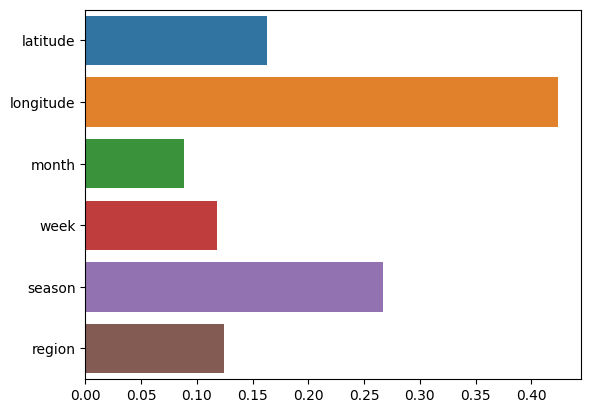

In [139]:
xgb = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

te_preds1, tr_preds1 ,*_ = cv_it(model=xgb, X_train=X_train, y_train=y_train_one, X_test=X_val, y_test=y_val_one, splits=10, cv_predict=True, task='clf')

In [144]:
y_train_one.value_counts(normalize=True)

0    0.560513
1    0.439487
dtype: float64

In [145]:
pd.Series(np.round(np.mean(te_preds1, axis=1))).value_counts(normalize=True)

0.0    0.55295
1.0    0.44705
dtype: float64

In [141]:
analyize_matches(y_val_one , np.round(np.mean(te_preds1, axis=1)))

analyize_matches(y_train_one, tr_preds1)

Exact matches:  0.7842907385697538
Missed by 1:  0.21570926143024619
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 33.529 % - prevalence: 43.923 %
Severity 2 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 3 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 4 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.0 %

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1435
           1       0.75      0.76      0.76      1124

    accuracy                           0.78      2559
   macro avg       0.78      0.78      0.78      2559
weighted avg       0.78      0.78      0.78      2559

Exact matches:  0.7860147576029239
Missed by 1:  0.21398524239707606
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 34.57 % - prevalence: 43.949 %
Severity 2 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 3 : accuracy: 0.0 % - prevalence: 0.0 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=12000,
              reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'month' 'week' 'season' 'region']
----------------------------------Fold-0------------------------------------
Training on 13050 samples
Validating on 872 samples
0    0.761468
1    0.238532
dtype: float64
Train RMSE:  0.39216463

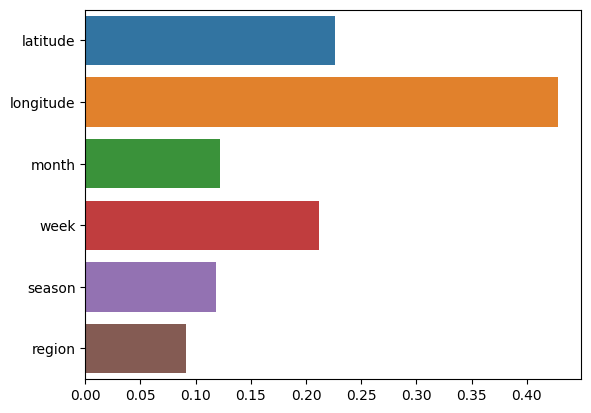

In [146]:
xgb = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

te_preds2, tr_preds2 ,*_ = cv_it(model=xgb, X_train=X_train, y_train=y_train_two, X_test=X_val, y_test=y_val_two, splits=10, cv_predict=True, task='clf')

In [151]:
print(y_train_two.value_counts(normalize=True))
print(pd.Series(np.round(np.mean(te_preds2, axis=1))).value_counts(normalize=True))
print()

analyize_matches(y_val_two , np.round(np.mean(te_preds2, axis=1)))
analyize_matches(y_train_two, tr_preds2)

0    0.810565
1    0.189435
dtype: float64
0.0    0.944119
1.0    0.055881
dtype: float64

Exact matches:  0.7909339585775693
Missed by 1:  0.20906604142243063
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 1.954 % - prevalence: 19.226 %
Severity 2 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 3 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 4 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.0 %

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      2067
           1       0.35      0.10      0.16       492

    accuracy                           0.79      2559
   macro avg       0.58      0.53      0.52      2559
weighted avg       0.73      0.79      0.74      2559

Exact matches:  0.79732432246052
Missed by 1:  0.20267567753948004
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 2.345 % - prevalence: 18.944 %
Severity

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=12000,
              reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'month' 'week' 'season' 'region']
----------------------------------Fold-0------------------------------------
Training on 13050 samples
Validating on 853 samples
0    0.845252
1    0.154748
dtype: float64
Train RMSE:  0.32601154

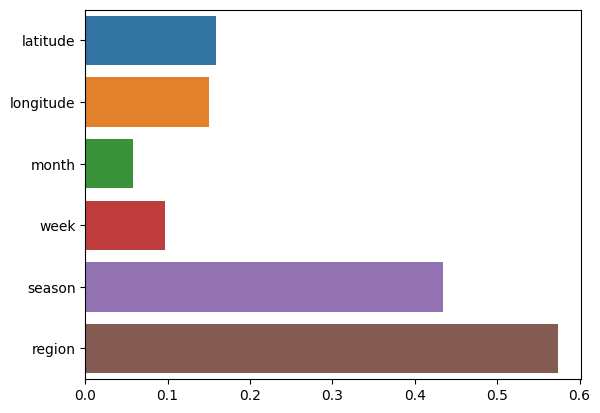

In [153]:
xgb = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

te_preds3, tr_preds3 ,*_ = cv_it(model=xgb, X_train=X_train, y_train=y_train_three, X_test=X_val, y_test=y_val_three, splits=10, cv_predict=True, task='clf')

In [156]:
print(y_train_three.value_counts(normalize=True))
print(pd.Series(np.round(np.mean(te_preds3, axis=1))).value_counts(normalize=True))
print()

analyize_matches(y_val_three , np.round(np.mean(te_preds3, axis=1)))
analyize_matches(y_train_three, tr_preds3)

0    0.840425
1    0.159575
dtype: float64
0.0    0.930832
1.0    0.069168
dtype: float64

Exact matches:  0.8515044939429465
Missed by 1:  0.14849550605705353
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 3.947 % - prevalence: 15.826 %
Severity 2 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 3 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 4 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.0 %

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2154
           1       0.57      0.25      0.35       405

    accuracy                           0.85      2559
   macro avg       0.72      0.61      0.63      2559
weighted avg       0.82      0.85      0.83      2559

Exact matches:  0.8473208744224536
Missed by 1:  0.15267912557754637
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 4.407 % - prevalence: 15.958 %
Severi

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=12000,
              reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'month' 'week' 'season' 'region']
----------------------------------Fold-0------------------------------------
Training on 13050 samples
Validating on 864 samples
0    0.976852
1    0.023148
dtype: float64
Train RMSE:  0.15853737

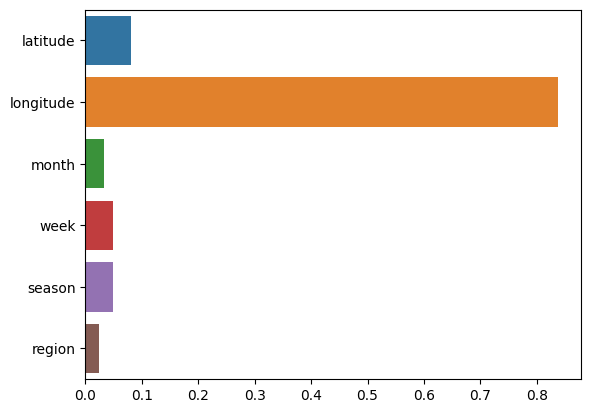

In [157]:
xgb = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

te_preds4, tr_preds4 ,*_ = cv_it(model=xgb, X_train=X_train, y_train=y_train_four, X_test=X_val, y_test=y_val_four, splits=10, cv_predict=True, task='clf')

In [159]:
print(y_train_four.value_counts(normalize=True))
print(pd.Series(np.round(np.mean(te_preds4, axis=1))).value_counts(normalize=True))
print()

analyize_matches(y_val_four , np.round(np.mean(te_preds4, axis=1)))
analyize_matches(y_train_four, tr_preds4)

0    0.791739
1    0.208261
dtype: float64
0.0    0.798359
1.0    0.201641
dtype: float64

Exact matches:  0.9620945681906995
Missed by 1:  0.037905431809300505
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 18.484 % - prevalence: 20.594 %
Severity 2 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 3 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 4 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.0 %

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2032
           1       0.92      0.90      0.91       527

    accuracy                           0.96      2559
   macro avg       0.95      0.94      0.94      2559
weighted avg       0.96      0.96      0.96      2559

Exact matches:  0.9612440521343356
Missed by 1:  0.038755947865664435
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 18.675 % - prevalence: 20.826 %
Se

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None, gpu_id=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=12000,
              reg_alpha=None, reg_lambda=None, ...)
Using cols:  ['latitude' 'longitude' 'month' 'week' 'season' 'region']
----------------------------------Fold-0------------------------------------
Training on 13050 samples
Validating on 862 samples
0    0.99768
1    0.00232
dtype: float64
Train RMSE:  0.0454858826

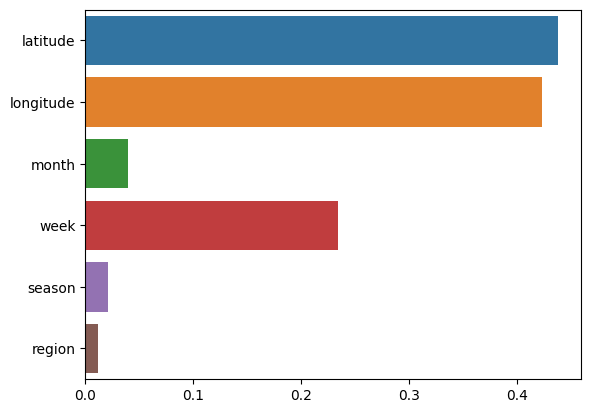

In [160]:
xgb = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
print(xgb)

te_preds5, tr_preds5 ,*_ = cv_it(model=xgb, X_train=X_train, y_train=y_train_five, X_test=X_val, y_test=y_val_five, splits=10, cv_predict=True, task='clf')

In [161]:
print(y_train_five.value_counts(normalize=True))
print(pd.Series(np.round(np.mean(te_preds5, axis=1))).value_counts(normalize=True))
print()

analyize_matches(y_val_five , np.round(np.mean(te_preds5, axis=1)))
analyize_matches(y_train_five, tr_preds4)

0    0.996759
1    0.003241
dtype: float64
0.0    0.998828
1.0    0.001172
dtype: float64

Exact matches:  0.9945291129347401
Missed by 1:  0.005470887065259867
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 0.43 %
Severity 2 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 3 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 4 : accuracy: 0.0 % - prevalence: 0.0 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.0 %

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2548
           1       0.00      0.00      0.00        11

    accuracy                           0.99      2559
   macro avg       0.50      0.50      0.50      2559
weighted avg       0.99      0.99      0.99      2559

Exact matches:  0.7944279704847942
Missed by 1:  0.20557202951520584
Missed by 2:  0.0
Missed by 3:  0.0
Missed by 4:  0.0

Severity 1 : accuracy: 0.083 % - prevalence: 0.324 %
Severity 2

`The real clash begins here`

In [174]:
tr_preds1.shape

(14501,)

In [412]:
preds = pd.DataFrame(columns= ['ones', 'twos', 'threes', 'fours', 'fives'], index=y_train.index)
preds['ones'] = tr_preds1
preds['twos'] = tr_preds2
preds['threes'] = tr_preds3
preds['fours'] = tr_preds4
preds['fives'] = tr_preds5

preds

,ones,twos,threes,fours,fives
4206,0.0,0.0,0.0,1.0,0.0
19524,0.0,0.0,0.0,1.0,0.0
17055,0.0,0.0,0.0,0.0,0.0
13684,1.0,0.0,0.0,0.0,0.0
4849,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
6123,1.0,0.0,0.0,0.0,0.0
8422,0.0,0.0,0.0,1.0,0.0
15949,1.0,0.0,0.0,0.0,0.0
16432,0.0,0.0,1.0,0.0,0.0


In [233]:
preds.sum(axis=1).value_counts()

1.0    11403
0.0     2912
2.0      186
dtype: int64

In [234]:
overlapped = preds[preds.sum(axis=1) != 1]
overlapped

,ones,twos,threes,fours,fives
17055,0.0,0.0,0.0,0.0,0.0
17888,1.0,1.0,0.0,0.0,0.0
10466,0.0,0.0,0.0,0.0,0.0
19978,0.0,0.0,0.0,0.0,0.0
17375,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
21407,0.0,0.0,0.0,0.0,0.0
2775,0.0,0.0,0.0,0.0,0.0
11762,0.0,0.0,0.0,0.0,0.0
16579,0.0,0.0,0.0,0.0,0.0


In [235]:
preds_sev_v0 = np.argmax(preds.values, axis=1) + 1
rmse(y_train, preds_sev_v0)

0.8813869617520211

In [236]:
overlapped.sum(axis=0)

ones      102.0
twos      114.0
threes     99.0
fours      53.0
fives       4.0
dtype: float64

In [237]:
preds_temp = preds[~preds.index.isin(overlapped.index)]
preds_temp['sev_v0'] = np.argmax(preds_temp.values, axis=1) + 1
preds_temp

,ones,twos,threes,fours,fives,sev_v0
4206,0.0,0.0,0.0,1.0,0.0,4
19524,0.0,0.0,0.0,1.0,0.0,4
13684,1.0,0.0,0.0,0.0,0.0,1
4849,0.0,0.0,0.0,1.0,0.0,4
9014,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...
6123,1.0,0.0,0.0,0.0,0.0,1
8422,0.0,0.0,0.0,1.0,0.0,4
15949,1.0,0.0,0.0,0.0,0.0,1
16432,0.0,0.0,1.0,0.0,0.0,3


In [238]:
analyize_matches(y_train.drop(overlapped.index), preds_temp['sev_v0'])
rmse(y_train.drop(overlapped.index), preds_temp['sev_v0'])

Exact matches:  0.7496272910637551
Missed by 1:  0.1924932035429273
Missed by 2:  0.05270542839603613
Missed by 3:  0.004647899675523985
Missed by 4:  0.0005261773217574323

Severity 1 : accuracy: 43.445 % - prevalence: 46.847 %
Severity 2 : accuracy: 2.719 % - prevalence: 15.47 %
Severity 3 : accuracy: 5.341 % - prevalence: 12.558 %
Severity 4 : accuracy: 23.459 % - prevalence: 24.897 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.228 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.74      0.93      0.83      5342
         2.0       0.41      0.18      0.25      1764
         3.0       0.56      0.43      0.49      1432
         4.0       0.92      0.94      0.93      2839
         5.0       0.00      0.00      0.00        26

    accuracy                           0.75     11403
   macro avg       0.53      0.49      0.50     11403
weighted avg       0.71      0.75      0.72     11403



0.6734722350289629

In [241]:
len(overlapped) + len(preds_temp) == len(preds)

True

In [244]:
analyize_matches(y_train.loc[overlapped.index], np.argmax(overlapped.values, axis=1) + 1)
rmse(y_train.loc[overlapped.index], np.argmax(overlapped.values, axis=1) + 1)
# so these 3k samples are the trouble makers!

Exact matches:  0.33892834086507423
Missed by 1:  0.3302130406714009
Missed by 2:  0.27727566171723694
Missed by 3:  0.04712717882504842
Missed by 4:  0.006455777921239509

Severity 1 : accuracy: 33.021 % - prevalence: 33.28 %
Severity 2 : accuracy: 0.323 % - prevalence: 31.73 %
Severity 3 : accuracy: 0.516 % - prevalence: 28.47 %
Severity 4 : accuracy: 0.032 % - prevalence: 5.842 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.678 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.34      0.99      0.51      1031
         2.0       0.31      0.01      0.02       983
         3.0       0.31      0.02      0.03       882
         4.0       1.00      0.01      0.01       181
         5.0       0.00      0.00      0.00        21

    accuracy                           0.34      3098
   macro avg       0.39      0.21      0.11      3098
weighted avg       0.36      0.34      0.18      3098



1.4024096205123582

In [253]:
((len(overlapped) * 1.402) + (len(preds_temp) * 0.6734)) / len(preds)

0.8290584235569961

In [246]:
rmse(y_train, preds_sev_v0)  # why the difference?

0.8813869617520211

In [257]:
overlapped[['threes', 'fours', 'fives']].sum(axis=1).value_counts()
# out of 3k samples, only 52 samples come from these 3 cols, so the problem of the problem lies in classifying 1s and 2s.

0.0    2994
2.0      52
1.0      52
dtype: int64

In [264]:
overlapped345  = overlapped.loc[overlapped[overlapped[['threes', 'fours', 'fives']].sum(axis=1) == 2].index]
rmse(y_train.loc[overlapped345.index], np.argmax(overlapped345.values, axis=1) + 1)

0.8879535677396304

In [267]:
rmse(y_train.loc[overlapped345.index], np.argmax(overlapped345.values, axis=1) + 2)

0.820412654142367

In [266]:
np.argmax(overlapped345.values, axis=1) + 1

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [268]:
overlapped12s = overlapped.loc[overlapped[overlapped[['ones', 'twos']].sum(axis=1) == 2].index]
rmse(y_train.loc[overlapped12s.index], np.argmax(overlapped12s.values, axis=1) + 1)

0.9239364353597956

In [269]:
overlapped23s = overlapped.loc[overlapped[overlapped[['twos', 'threes']].sum(axis=1) == 2].index]
rmse(y_train.loc[overlapped23s.index], np.argmax(overlapped23s.values, axis=1) + 1)

0.944911182523068

In [271]:
overlapped123s = overlapped.loc[overlapped[overlapped[['ones', 'twos', 'threes']].sum(axis=1) == 2].index]
rmse(y_train.loc[overlapped123s.index], np.argmax(overlapped123s.values, axis=1) + 1)

0.9922778767136676

In [383]:
# sanity check
preds_temp[['ones', 'twos', 'threes', 'fours', 'fives']].sum(axis=1).value_counts()

1.0    11403
dtype: int64

In [399]:
overlapped_preds = np.argmax(overlapped.values, axis=1) + 1
pd.Series(overlapped_preds).value_counts(normalize=True)

1    0.972886
3    0.016462
2    0.010329
4    0.000323
dtype: float64

In [388]:
overlapped_densities = data.loc[overlapped.index]
overlapped_densities

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
17055,stmj,35.570000,-78.944303,2018-08-28,train,2018,8,35,3,south,2.0,51498.0
17888,troi,35.692854,-79.187992,2017-07-20,train,2017,7,29,3,south,1.0,14684.0
10466,llws,35.837000,-79.001000,2015-03-24,train,2015,3,13,2,south,2.0,32139.0
19978,waiv,35.897724,-79.059636,2016-05-09,train,2016,5,19,2,south,2.0,68983.0
17375,tcnf,35.680558,-79.210830,2017-05-17,train,2017,5,20,2,south,1.0,12707.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21407,xqkf,39.399200,-99.424810,2017-07-24,train,2017,7,30,3,midwest,3.0,708750.0
2775,dbvn,39.792190,-99.971050,2018-06-11,train,2018,6,24,3,midwest,4.0,1581300.0
11762,mxoi,35.668129,-79.233916,2016-06-21,train,2016,6,25,3,south,2.0,79875.0
16579,sgmf,42.772240,-118.447000,2017-09-14,train,2017,9,37,4,west,3.0,328224.0


In [387]:
rmse(y_train[overlapped.index], overlapped_preds)

1.4024096205123582

In [400]:
# cost if all overlappings are classified as 1s

overlapped_preds = np.where(overlapped_preds == 1, 2, overlapped_preds)
pd.Series(overlapped_preds).value_counts(normalize=True)

2    0.983215
3    0.016462
4    0.000323
dtype: float64

In [406]:
(len(overlapped_preds) * 1.402  + len(preds_temp) * 0.6734) / len(preds)

1.8467244546850998

In [408]:
rmse(y_train[overlapped.index], overlapped_preds) # better

0.9358024764960495

In [409]:
(len(overlapped_preds) * 0.935  + len(preds_temp) * 0.6734) / len(preds)

1.6244869738863288

In [403]:
y_train[overlapped.index].value_counts(normalize=True)

1.0    0.332795
2.0    0.317301
3.0    0.284700
4.0    0.058425
5.0    0.006779
Name: severity, dtype: float64

In [411]:
preds

array([4., 3., 1., ..., 1., 4., 3.])

In [438]:
# what if probabilities are used?

new_preds = []

for row in tqdm(preds.itertuples(), total=len(preds)):
    if sum(row[1:6]) == 1:
        new_preds.append(np.argmax(row[1:6]) + 1)
    elif sum(row[1:4]) == 2:
        new_preds.append(2)
    elif sum(row[4:]) == 2:
        new_preds.append(4)
    else:
        new_preds.append(2)

len(new_preds) == len(preds)

100%|██████████| 14501/14501 [00:00<00:00, 129638.53it/s]


True

In [439]:
# definitely can't believe this ○_○ •
rmse(y_train, new_preds)

0.7424771552354184

In [431]:
preds

,ones,twos,threes,fours,fives
4206,0.0,0.0,0.0,1.0,0.0
19524,0.0,0.0,0.0,1.0,0.0
17055,0.0,0.0,0.0,0.0,0.0
13684,1.0,0.0,0.0,0.0,0.0
4849,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
6123,1.0,0.0,0.0,0.0,0.0
8422,0.0,0.0,0.0,1.0,0.0
15949,1.0,0.0,0.0,0.0,0.0
16432,0.0,0.0,1.0,0.0,0.0


## viz

In [274]:
# what are these samples?

import geopandas as gpd
from shapely.geometry import Point

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

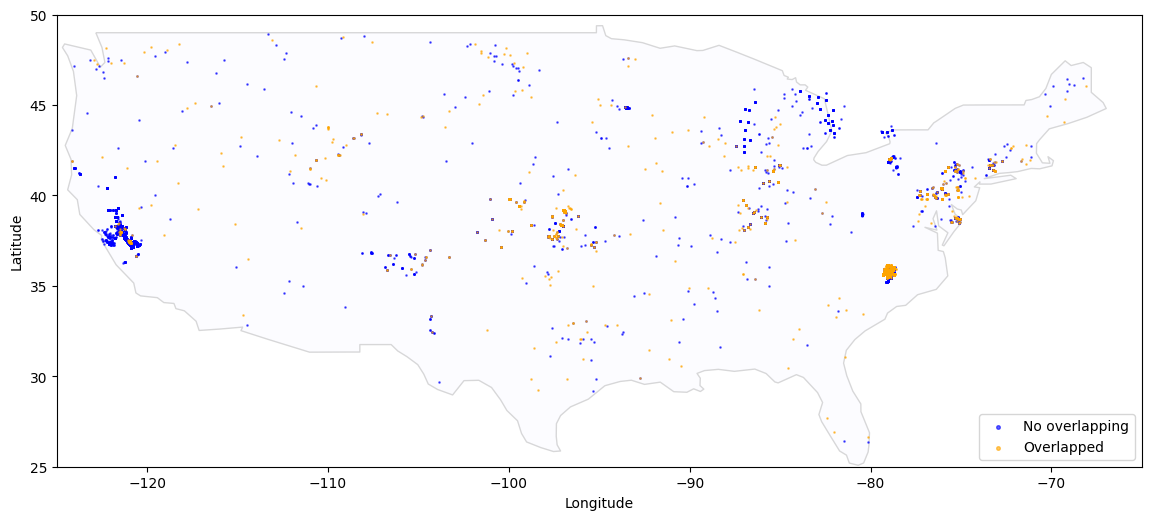

In [380]:
fig, ax = plt.subplots(figsize=(14, 9))

# map the preds_temp
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
preds_temp_ = data.loc[preds_temp.index]
geometry = [Point(xy) for xy in zip(preds_temp_["longitude"], preds_temp_["latitude"])]
gdf = gpd.GeoDataFrame(preds_temp_, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="No overlapping", alpha=0.6)

# map the overlapped
overlapped_ = data.loc[overlapped.index]
geometry = [Point(xy) for xy in zip(overlapped_["longitude"], overlapped_["latitude"])]
gdf = gpd.GeoDataFrame(overlapped_, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Overlapped", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

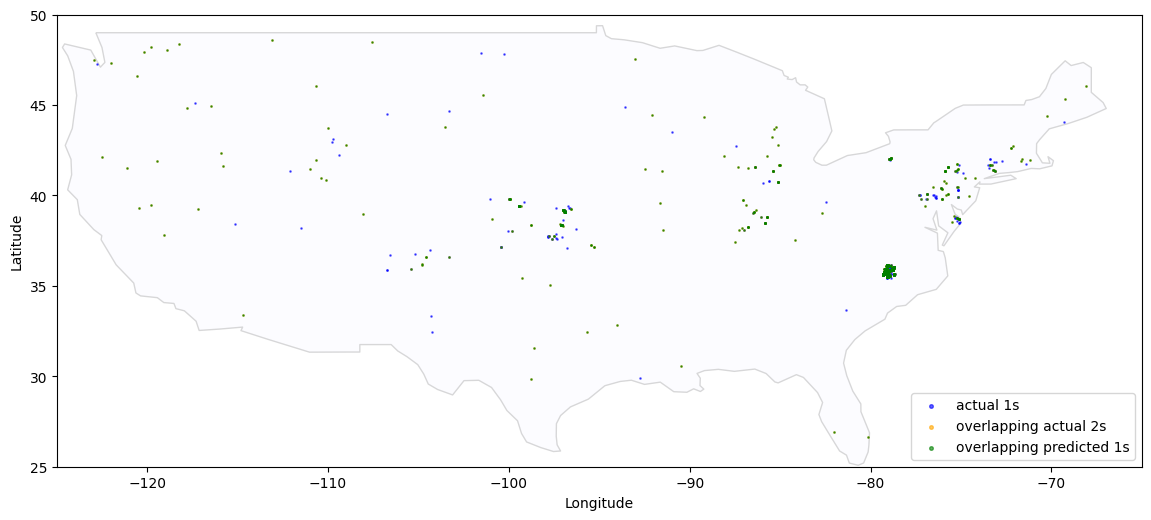

In [381]:
fig, ax = plt.subplots(figsize=(14, 9))

# map the preds_temp
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
preds_temp_ = overlapped_[overlapped_.severity == 1]
geometry = [Point(xy) for xy in zip(preds_temp_["longitude"], preds_temp_["latitude"])]
gdf = gpd.GeoDataFrame(preds_temp_, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="actual 1s", alpha=0.6)

# map the overlapped
overlapped_ = overlapped_df[overlapped_df.severity == 2]
geometry = [Point(xy) for xy in zip(overlapped_["longitude"], overlapped_["latitude"])]
gdf = gpd.GeoDataFrame(overlapped_, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="overlapping actual 2s", alpha=0.6)


overlapped_ = overlapped_[overlapped_.severity == 2]
geometry = [Point(xy) for xy in zip(overlapped_["longitude"], overlapped_["latitude"])]
gdf = gpd.GeoDataFrame(overlapped_, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="green", label="overlapping predicted 1s", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

In [354]:
overlapped_df = data.loc[overlapped.index]
overlapped_df

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
17055,stmj,35.570000,-78.944303,2018-08-28,train,2018,8,35,3,south,2.0,51498.0
17888,troi,35.692854,-79.187992,2017-07-20,train,2017,7,29,3,south,1.0,14684.0
10466,llws,35.837000,-79.001000,2015-03-24,train,2015,3,13,2,south,2.0,32139.0
19978,waiv,35.897724,-79.059636,2016-05-09,train,2016,5,19,2,south,2.0,68983.0
17375,tcnf,35.680558,-79.210830,2017-05-17,train,2017,5,20,2,south,1.0,12707.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21407,xqkf,39.399200,-99.424810,2017-07-24,train,2017,7,30,3,midwest,3.0,708750.0
2775,dbvn,39.792190,-99.971050,2018-06-11,train,2018,6,24,3,midwest,4.0,1581300.0
11762,mxoi,35.668129,-79.233916,2016-06-21,train,2016,6,25,3,south,2.0,79875.0
16579,sgmf,42.772240,-118.447000,2017-09-14,train,2017,9,37,4,west,3.0,328224.0


In [355]:
overlapped_df_X = overlapped_df.drop(drop_cols, axis=1)
overlapped_df_y = overlapped_df['severity']

overlapped_df_X.week = overlapped_df_X.week.astype('int')
overlapped_df_X.region = overlapped_df_X.region.map(reg_map)

Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region']
----------------------------------Fold-0------------------------------------
Training on 2788 samples
Validating on 234 samples
1.0    0.371795
2.0    0.346154
3.0    0.243590
4.0    0.034188
5.0    0.004274
Name: severity, dtype: float64
Train RMSE:  0.8348145611490352
Val RMSE: 0.8819171036881969
----------------------------------Fold-1------------------------------------
Training on 2788 samples
Validating on 219 samples
1.0    0.378995
2.0    0.319635
3.0    0.255708
4.0    0.036530
5.0    0.009132
Name: severity, dtype: float64
Train RMSE:  0.844213997770449
Val RMSE: 0.8574146122801957
----------------------------------Fold-2------------------------------------
Training on 2788 samples
Validating on 243 samples
1.0    0.362140
2.0    0.316872
3.0    0.263374
4.0    0.053498
5.0    0.004115
Name: severity, dtype: float64
Train RMSE:  0.8309386923675282
Val RMSE: 0.9162456945817024
-----------------------

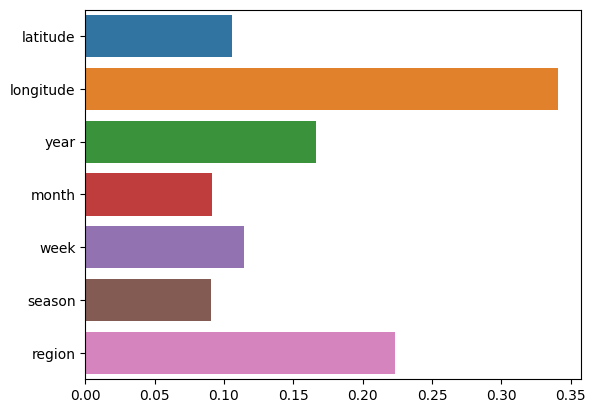

In [356]:
# Meta learing ovelapping samples

xgb = XGBRegressor(n_estimators=300, learning_rate=0.007, n_jobs=-1, random_state=4200)
_ = cv_it(xgb, overlapped_df_X, overlapped_df_y, task='reg')

In [357]:
# 0.9350636960334924 
# 0.8817464357545273
# 

In [370]:
y_train.loc[overlapped.index]

17055    2.0
17888    1.0
10466    2.0
19978    2.0
17375    1.0
        ... 
21407    3.0
2775     4.0
11762    2.0
16579    3.0
11976    3.0
Name: severity, Length: 3098, dtype: float64

In [372]:
rmse(overlapped_df_y, np.argmax(overlapped_df_X.values, axis=1)+1)
# so meta learner is better ?! or overfitting?! Biggest problem is test_data not having single common lat_lng ---> How to tackle this?

1.3168226720576055

# Test Predictions

In [359]:
drop_cols = ['date', 'uid', 'severity', 'split', 'density']

In [360]:
X_train = tr_data.drop(columns=drop_cols)
X_train.week = X_train.week.astype('int')
X_train.region = X_train.region.map(reg_map)  # reg map is better than reg_sev_map
y_train = tr_data.severity

X_val = val_data.drop(columns=drop_cols)
X_val.week = X_val.week.astype('int')
X_val.region = X_val.region.map(reg_map)
y_val = val_data.severity

In [361]:
X_train.columns.to_list() == X_val.columns.to_list()

True

In [362]:
X_test = X_test[X_train.columns]
assert X_test.columns.tolist() == X_train.columns.tolist()

X_test

,latitude,longitude,year,month,week,season,region
1,36.559700,-121.510000,2016,8,35,3,2
12,33.042600,-117.076000,2014,11,44,4,2
14,40.703968,-80.293050,2015,8,35,3,1
15,38.972500,-94.672930,2019,8,35,3,3
16,34.279000,-118.905000,2018,1,2,1,2
...,...,...,...,...,...,...,...
23556,40.136410,-80.473740,2019,7,28,3,1
23560,36.875400,-121.561000,2019,9,38,4,2
23563,34.210000,-78.929389,2019,7,29,3,0
23565,36.708500,-121.749000,2014,12,49,1,2


In [363]:
all_X_train = pd.concat([X_train, X_val], axis=0)
all_y_train = pd.concat([y_train, y_val], axis=0)

assert all_X_train.shape[0] == all_y_train.shape[0]
assert all_X_train.columns.tolist() == X_test.columns.tolist()

all_X_train.shape, all_y_train.shape

((17060, 7), (17060,))

In [364]:
X_test.week = X_test.week.astype('int')
X_test.region = X_test.region.map(reg_map)

In [365]:
all_y_train = all_y_train - 1
all_y_train.value_counts()

0.0    7497
3.0    3547
1.0    3239
2.0    2719
4.0      58
Name: severity, dtype: int64

In [ ]:
xgb_reg = XGBClassifier(n_estimators=2000, max_depth=5, learning_rate=0.05, n_jobs=-1, random_state=12_000, tree_method='gpu_hist', gpu_id=0)
test_preds_cv, train_preds_cv,  *_ = cv_it(xgb_reg, all_X_train, all_y_train, X_test=X_test, splits=10, cv_predict=True, task='clf')
test_preds_cv.shape

In [ ]:
test_preds_cv

array([[3., 3., 3., ..., 3., 3., 3.],
       [0., 3., 3., ..., 3., 3., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 0., 3., ..., 3., 3., 0.]])

In [ ]:
preds = np.round(np.mean(test_preds_cv, axis=1) + 1)
pd.Series(preds).value_counts(normalize=True)

1.0    0.408909
4.0    0.248541
3.0    0.187250
2.0    0.154224
5.0    0.001075
dtype: float64

## Submission

In [ ]:
# make submissions

sub_format.severity = preds.astype('int')                                   
sub_format.to_csv('../submissions/to submit/xgb_clf_cv_preds.csv', index=False)
